# Find wheels and rims in images, write rims as json file ##

Develop techniques for finding wheels (connected regions) in images and the rims that surround them.

## Read image from file 

In [328]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
#
# Control batch file numbers from  0001 to 0020
# Irradiated batch file numbers from 0001 to 0020
imFile = "Images/ControlBatch/0001.bmp"
#imFile = "Images/IrradiatedBatch/0001.bmp"
#
# Evidence tuning needed in e.g. Control 0019, Control 0012, Irradiated 0018
#
# Read in image
imgRaw = plt.imread(imFile)
#
print(" ")
print("File " + imFile + " read.")
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 18:02:42.373258
 
File Images/ControlBatch/0001.bmp read.
 
Date and time 2021-01-29 18:02:42.462054
Time since last check is 0:00:00.088796


## Routines for converting RGBA images to RGB and RGB to greyscale

In [329]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    #
    return np.asarray(grey, dtype = np.uint8)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 18:02:42.473021
 
Date and time 2021-01-29 18:02:42.474018
Time since last check is 0:00:00.000997


## Ceiling division

In [330]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 18:02:42.483958
 
Date and time 2021-01-29 18:02:42.483958
Time since last check is 0:00:00


## Initial image processing

Open image, convert to grey scale and apply a range of increasing thresholds.

Date and time  2021-01-29 18:02:42.511882
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 1040 of columns 1392 of pixels 1447680 and depth 4
Maximum value in pixels 244
 
Number of thresholds 2
Number of rows in figure 3
 


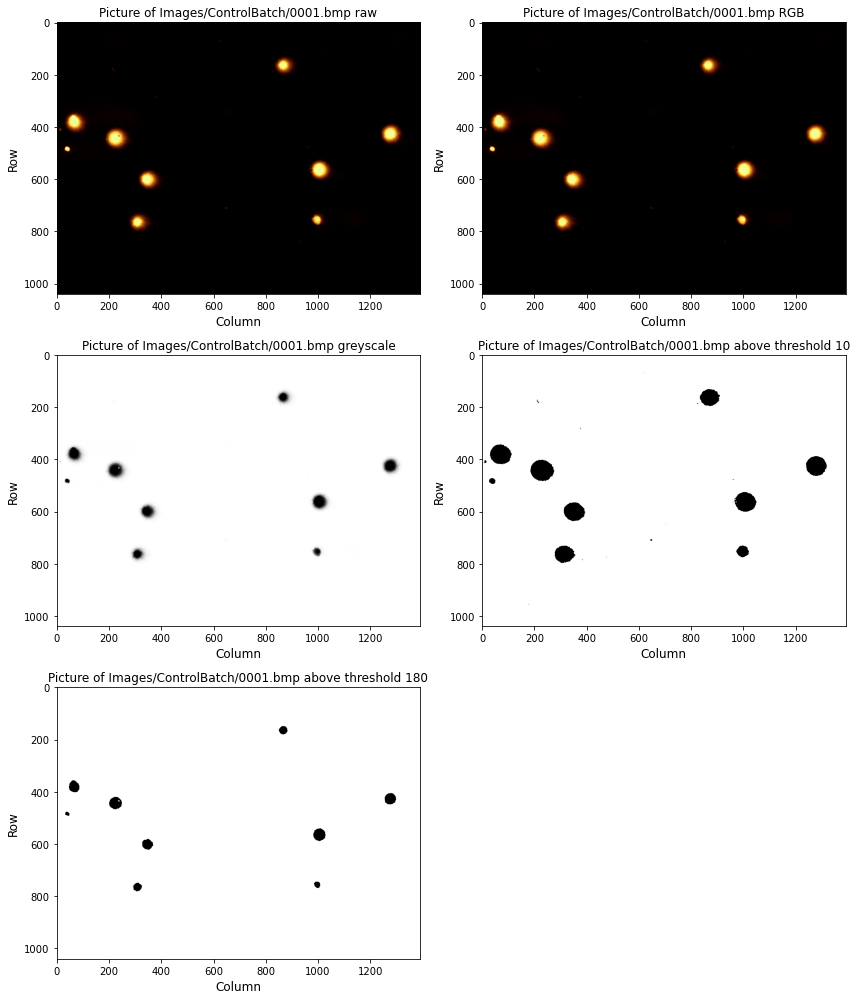

 
Date and time 2021-01-29 18:02:44.363908
Time since last check is 0:00:01.852026


In [331]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
# 
# Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
nRows = imgRaw.shape[0] 
nCols = imgRaw.shape[1]
nDepth = imgRaw.shape[2]
img = np.zeros((nRows, nCols))
#
# Determine image format and process accordingly
if nDepth == 4:
    imgRGB = rgba2rgb(imgRaw)
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 3:
    imgRGB = imgRaw
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 1:
    imgRGB = imgRaw
    imgGrey = imgRaw
else:
    print(" ")
    print("Unexpected image depth",nDepth)
    sys.stop()
#
print("Type of raw image file is",imgRaw.dtype)
print("Type of greyscale image file is",imgGrey.dtype)
print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
print("Maximum value in pixels",np.amax(imgGrey))
#
# Set thresholds for applying to image (lowest to highest)
thresh = np.array([10, 180]) 
nThresh = len(thresh)
imgThr = np.zeros((nRows, nCols, nThresh))
#
# Plot image at various stages of processing
nFigRows = 2 + ceilDiv(nThresh, 2)
print(" ")
print("Number of thresholds",nThresh)
print("Number of rows in figure",nFigRows)
for nT in range(0, nThresh):
    imgThr[:, :, nT] = imgGrey > thresh[nT]
#
print(" ")
fig = plt.figure(figsize=(nFigRows*4, 14))
fig.add_subplot(nFigRows, 2, 1)
plt.title("Picture of " + imFile + " raw")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRaw, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 2)
plt.title("Picture of " + imFile + " RGB")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRGB, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 3)
plt.title("Picture of " + imFile + " greyscale")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgGrey, cmap = "Greys")
#
for nT in range(0, nThresh):
    fig.add_subplot(nFigRows, 2, 4 + nT)
    plt.title("Picture of " + imFile + " above threshold " + str(thresh[nT]))
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgThr[:, :, nT], cmap = "Greys")
#
plt.tight_layout()
plt.savefig("imageD.png")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Identify clusters using watershed algorithm

Identify clusters at the lowest threshold and heads at the higher threshold.

Date and time 2021-01-29 18:02:44.405799
 
Cluster ID using Watershed algorithm
Cluster threshold 10, head threshold 180.
Min number of pixesl in cluster 200, max number 200000.
Min number of pixesl in cluster 200, max number 200000.
 


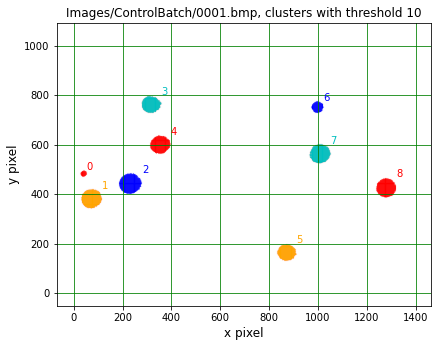

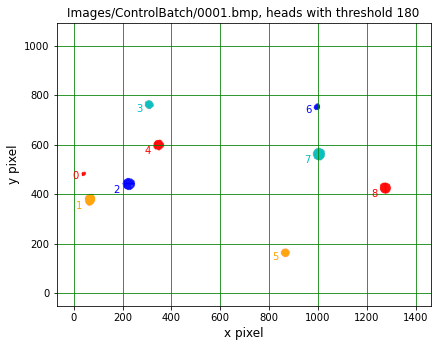

 
Date and time 2021-01-29 18:02:45.467891
Time since last check is 0:00:01.062092


In [332]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
#
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
#
debug = False
if debug:
    print("Running in debug mode!")
#
minClusPixels = 200
maxClusPixels = 200000
minHeadPixels = 40
maxHeadPixels = 20000
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b, head threshold",thresh[1],"\b.")
print("Min number of pixesl in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixesl in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
#
# Define grid of markers and background marker value:
nStepCols = 3
nStepRows = 3
rMark, cMark = np.ogrid[0:nRows:nStepRows, 0:nCols:nStepCols]
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
mStart = 1
markers = np.zeros((nRows, nCols)).astype(np.int)
markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(markers, cmap = "CMRmap");
#
# Create image with cluster threshold and run watershed algorithm
clusImg = imgGrey > thresh[0]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusImg);
colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
#
# Remove "isolated" markers (i.e. in regions where no cluster found)
colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions
mMaxClus = np.amax(colDotsClus)
#
# Positions of marker values
boolClus = colDotsClus >= mStart
nFoundClus = len(np.unique(colDotsClus[boolClus]))
rMarkerClus = np.zeros(nFoundClus)
rMarkerClus = np.unique(colDotsClus[boolClus])
#
# Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nClus = 0
cMarkerClus = np.zeros(nFoundClus)
maxInDotClus = 0
for nR in range(0, nFoundClus):
    boolClus = colDotsClus == rMarkerClus[nR]
    nHereCl = np.sum(boolClus)
    if nHereCl < minClusPixels or nHereCl > maxClusPixels:
        continue
    maxInDotClus = max(maxInDotClus, nHereCl)
    cMarkerClus[nClus] = rMarkerClus[nR]
    nClus += 1
#
# Create image with head threshold and run watershed algorithm
headImg = imgGrey > thresh[1]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headImg);
colDotsHead = ndimage.watershed_ift(headImg.astype(np.uint8), markers)
#
# Remove "isolated" markers
colDotsHead[rMark, cMark] = colDotsHead[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions.
mMaxHead = np.amax(colDotsHead)
#
# Positions of marker values that are not background
boolHead = colDotsHead > mStart
nFoundHead = len(np.unique(colDotsHead[boolHead]))
rMarkerHead = np.zeros(nFoundHead)
rMarkerHead = np.unique(colDotsHead[boolHead])
#
# Select the heads, first pass (determine accepted number). Must exclude tiny clusters (noise) and the large
# cluster which is the remainder of the image.
nHead = 0
cMarkerHead = np.zeros(nFoundHead)
maxInDotHead = 0
for nR in range(0, nFoundHead):
    boolHead = colDotsHead == rMarkerHead[nR]
    nHereHd = np.sum(boolHead)
    if nHereHd < minHeadPixels or nHereHd > maxHeadPixels:
        continue
    maxInDotHead = max(maxInDotHead, nHereHd) 
    cMarkerHead[nHead] = rMarkerHead[nR]
    nHead += 1
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
# Information on clusters
nInCluster = np.zeros(nClus).astype(int)
iClusSum = np.zeros(nClus)
#
# Information on pixels in clusters
lClus = np.sum(clusImg)
indexCl = np.zeros(lClus)
cPixelsCl = np.zeros(lClus)
rPixelsCl = np.zeros(lClus)
iPixelsCl = np.zeros(lClus)
#
# Information on head
nInHead = np.zeros(nHead).astype(int)
iHeadSum = np.zeros(nHead)
#
# Information on pixels in head (lHead must be large enough...)
lHead = lClus
indexHd = np.zeros(lHead)
cPixelsHd = np.zeros(lHead)
rPixelsHd = np.zeros(lHead)
iPixelsHd = np.zeros(lHead)
#
# Temporary information 
cPixelsHere = np.zeros(lClus)
rPixelsHere = np.zeros(lClus)
iPixelsHere = np.zeros(lClus)
#
# Find pixels in clusters, determine positions and plot 
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", clusters with threshold " + str(thresh[0]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffSet = 2
yOffSet = 2
nCol = 0
mSize = 0.001
#
nLastCl = 0
for nC in range(0, nClus):
    boolClus = colDotsClus == cMarkerClus[nC]
    nHereCl = np.sum(boolClus).astype(int)
    #
    nInCluster[nC] = nHereCl
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolClus)
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusSum[nC] = np.sum(iPixelsHere)
    #
    indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nInCluster[nC])
    cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
    rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
    iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere) + xOffSet
    cLab = np.amax(cPixelsHere) + yOffSet
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
# Find pixels in head, determine positions and plot
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", heads with threshold " + str(thresh[1]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffSet = 15.0
yOffSet = 35.0
nCol = 0
mSize = 0.001
#
nLastHd = 0
for nH in range(0, nHead):
    boolHead = colDotsHead == cMarkerHead[nH]
    nHereHd = np.sum(boolHead).astype(int)
    #
    nInHead[nH] = nHereHd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolHead)
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadSum[nH] = np.sum(iPixelsHere)
    #
    indexHd[nLastHd:nLastHd + nHereHd] = nC*np.ones(nInHead[nH])
    cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[:]
    rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[:]
    iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsHere) - xOffSet
    cLab = np.amin(cPixelsHere) - yOffSet
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Edge finding

Algorithm used is to shift logical array `picture` containing thresholded image left and right, forming array `imgL` and `imgR`. The arrays `imgL and (not picture)` and `imgR and (not picture)` then contain the left and right edges in the original image. Similarly, `imgU and (not picture)` and `imgD and (not picture)` contain the upper and lower egdes. Taking the logical or of these four arrays gives all edges.

In [333]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
def edgeFinder(picture, edgeWidth):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgL = np.full((nRows, nCols), False)
    imgR = np.full((nRows, nCols), False)
    imgD = np.full((nRows, nCols), False)
    imgU = np.full((nRows, nCols), False)
    #
    imgL[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgL[0:nRows, nCols - shiftC:nCols] = False
    imgR[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgR[0:nRows, 0:shiftC] = False
    imgD[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]
    imgD[nRows - shiftR:nRows, 0:nCols] = False
    imgU[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgU[0:shiftR, 0:nCols] = False
    #
    edges = (np.logical_or(np.logical_or(np.logical_and(picture, np.logical_not(imgR)), # left edge
                                         np.logical_and(picture, np.logical_not(imgL))), # right edge
                           np.logical_or(np.logical_and(picture, np.logical_not(imgU)), # upper edge
                                         np.logical_and(picture, np.logical_not(imgD))))) # lower edge
    #
    return edges
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2021-01-29 18:02:45.486596
 
Date and time 2021-01-29 18:02:45.487594
Time since last check is 0:00:00.000998


## Make image of clusters and their edges

Date and time 2021-01-29 18:02:45.508537
 


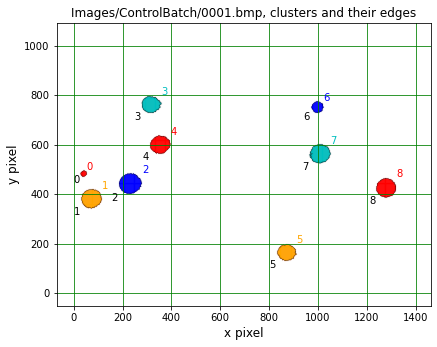

 
Date and time 2021-01-29 18:02:46.272472
Time since last check is 0:00:00.763935


In [334]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
clusPic = np.zeros((nRows, nCols))
headPic = np.zeros((nRows, nCols))
#
# Information on cluster edge
nInClusEd = np.zeros(nClus).astype(int)
iClusEdSum = np.zeros(nClus)
#
# Information on pixels in cluster edge
indexClEd = np.zeros(lClus)
cPixelsClEd = np.zeros(lClus)
rPixelsClEd = np.zeros(lClus)
iPixelsClEd = np.zeros(lClus)
#
# Pictures for display/edge finding
thisEdge = np.zeros((nRows, nCols))
thisEdgePic = np.zeros((nRows, nCols))
#
# Edge width required
width = 1
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", clusters and their edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
nCol = 0
mSize = 0.001
#
nLastCl = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    boolClus = colDotsClus == cMarkerClus[nC]
    nHereCl = np.sum(boolClus).astype(int)
    #
    nInCluster[nC] = nHereCl
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolClus)
    thisPic = np.zeros((nRows, nCols))
    thisPic[rPixelsHere, cPixelsHere] = 1
    clusPic += thisPic
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusSum[nC] = np.sum(iPixelsHere)
    #
    indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nInCluster[nC])
    cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
    rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
    iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
    cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
    # Edges
    thisEdge = edgeFinder(thisPic, width)
    nHereClEd = np.sum(thisEdge).astype(int)
    #
    nInClusEd[nC] = nHereClEd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(thisEdge)
    thisEdgePic[rPixelsHere, cPixelsHere] = 1
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusEdSum[nC] = np.sum(iPixelsHere)
    #
    indexClEd[nLastClEd:nLastClEd + nHereClEd] = nC*np.ones(nInClusEd[nC])
    cPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = cPixelsHere[:]
    rPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = rPixelsHere[:]
    iPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHere[0:nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsHere[0:nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastClEd = nLastClEd + nHereClEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make image of heads and their edges

Date and time 2021-01-29 18:02:46.302392
 


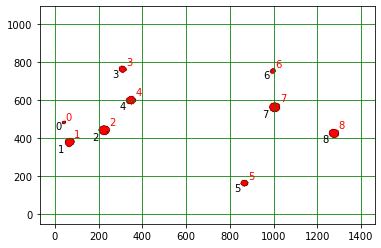

 
Date and time 2021-01-29 18:02:46.992524
Time since last check is 0:00:00.690132


In [335]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
# Figure control
xOffSet = 2
yOffSet = -14
mSize = 0.001
#
# Information on head edge
nInHeadEd = np.zeros(nHead).astype(int)
iHeadEdSum = np.zeros(nHead)
#
# Information on pixels in head edge
indexHdEd = np.zeros(lHead)
cPixelsHdEd = np.zeros(lHead)
rPixelsHdEd = np.zeros(lHead)
iPixelsHdEd = np.zeros(lHead)
#
# Pictures for display/edge finding
headPic = np.zeros((nRows, nCols))
#
nLastHd = 0
nLastHdEd = 0
nCol = 0
for nH in range(0, nHead):
    #
    # Clusters
    boolHead = colDotsHead == cMarkerHead[nH]
    nHereHd = np.sum(boolHead).astype(int)
    #
    nInHead[nH] = nHereHd
    #
    # Indices of x and y pixels
    thisPic = np.zeros((nRows, nCols))
    rPixelsHere, cPixelsHere = np.where(boolHead)
    thisPic[rPixelsHere, cPixelsHere] = 1
    headPic += thisPic
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadSum[nH] = np.sum(iPixelsHere)
    #
    indexHd[nLastHd:nLastHd + nHereHd] = nH*np.ones(nInHead[nH])
    cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[:]
    rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[:]
    iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere[0:nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHere[0:nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
    #
    # Edges
    thisEdge = edgeFinder(thisPic, width)
    nHereHdEd = np.sum(thisEdge).astype(int)
    #
    nInHeadEd[nH] = nHereHdEd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(thisEdge)
    thisEdgePic[rPixelsHere, cPixelsHere] = 1
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadEdSum[nH] = np.sum(iPixelsHere)
    #
    indexHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = nH*np.ones(nInHeadEd[nH])
    cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = cPixelsHere[:]
    rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = rPixelsHere[:]
    iPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHere) - yOffMin
    cLab = np.amin(cPixelsHere) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHdEd = nLastHdEd + nHereHdEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot clusters and heads together

Note that the index of a head and its associated cluster may be different!

Date and time 2021-01-29 18:02:47.008516
 


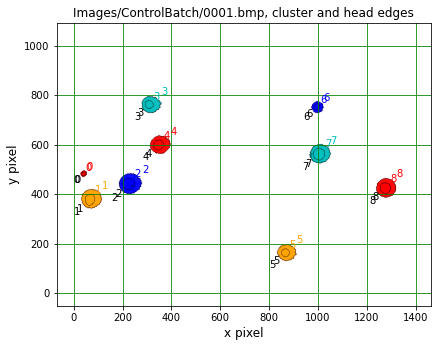

 
Date and time 2021-01-29 18:02:47.612847
Time since last check is 0:00:00.604331


In [336]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nCol = 0
#
nLastCl = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl]) + yOffMax
    cLab = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    # Edges
    nHereClEd = nInClusEd[nC] 
    plt.scatter(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd], rPixelsClEd[nLastClEd:nLastClEd + nHereClEd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastCl = nLastCl + nHereCl
    nLastClEd = nLastClEd + nHereClEd    
    #
nCol = 0
#
nLastHd = 0
nLastHdEd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    # Edges
    nHereHdEd = nInHeadEd[nH]
    plt.scatter(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - yOffMin
    cLab = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHd = nLastHd + nHereHd
    nLastHdEd = nLastHdEd + nHereHdEd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Select clusters by combining results from all thresholds

Select only low threshold clusters/edges (called wheels/rims in following) containing one high threshold cluster/edge (wheel/rim).

Produce and sort lists of coordinates that will be put into json file as "polygons". Sort according to the angles of the points about the centre of the rim. Choose the centre to be the mean position of the high threshold rim enclosed by the low threshold rim, or the mean position of the pixels in the low threshold rim.

Note that we need to add the first point to the end of the sorted list to close the polygon!

Date and time  2021-01-29 18:02:47.643799
 
Image size 1040 x 1392
Fiducial region, rows 5 to 1035
Fiducial region, columns 5 to 1387
Min number of point in wheel 500, in rim 100
Rim size, rows 20 to 200
Rim size, columns 50 to 500
Max ratio of rim size to wheel area 0.1
 


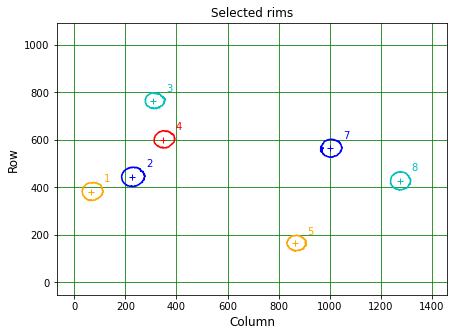

 
Number of polygons (nRimOut) 7
 


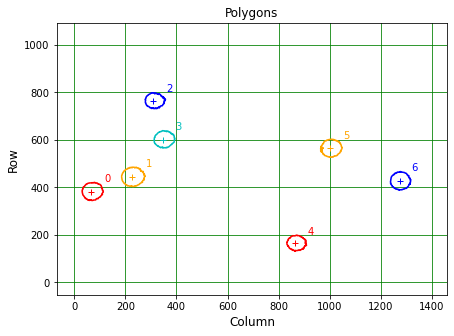

 
Date and time 2021-01-29 18:02:47.961903
Time since last check is 0:00:00.318104


In [337]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
debug = False
#
withLabels = True
#
# Choose low threshold or high threshold rim as centre in sorting procedure
centreLT = False
#
minRimPnts0 = 100
minWheelPnts0 = 500
rMin0 = 5
rMax0 = nRows - rMin0
cMin0 = 5
cMax0 = nCols - cMin0
rWidMin0 = 20
rWidMax0 = 200
cWidMin0 = 50
cWidMax0 = 500
maxRtoW = 0.1
print(" ")
print("Image size",nRows,"x",nCols)
print("Fiducial region, rows",rMin0,"to",rMax0)
print("Fiducial region, columns",cMin0,"to",cMax0)
print("Min number of point in wheel",minWheelPnts0,"\b, in rim",minRimPnts0)
print("Rim size, rows",rWidMin0,"to",rWidMax0)
print("Rim size, columns",cWidMin0,"to",cWidMax0)
print("Max ratio of rim size to wheel area",maxRtoW)
#
pnts_num = np.zeros(nClus).astype(int)
pnts_row = np.zeros((nClus, np.amax(nInClusEd)))
pnts_col = np.zeros((nClus, np.amax(nInClusEd)))
mean_row = np.zeros(nClus)
mean_col = np.zeros(nClus)
#
# Need additional entry in sorted arrays as must add initial point at end of array to complete polygon!
col_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
row_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
#
# Text positions
rTextRow = 3
rTextCol = 3
wTextRow = 28
wTextCol = 28
#
fig = plt.figure(figsize=(7, 5))
plt.title("Selected rims", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iSelRim = 0
nLastCl = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    rMinCl = np.amin(rPixelsCl[nLastCl:nLastCl + nHereCl])
    cMinCl = np.amin(cPixelsCl[nLastCl:nLastCl + nHereCl])
    rMaxCl = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl])
    cMaxCl = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl])
    rWidCl = rMaxCl - rMinCl
    cWidCl = cMaxCl - cMinCl
    #
    # Edges
    nHereClEd = nInClusEd[nC] 
    rMinClEd = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMinClEd = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rMaxClEd = np.amax(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMaxClEd = np.amax(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rWidClEd = rMaxClEd - rMinClEd
    cWidClEd = cMaxClEd - cMinClEd
    #
    rimToWheel = nInClusEd[nC]/nInCluster[nC]
    #
    if (nHereClEd > minRimPnts0 and nHereCl > minWheelPnts0 and
        rMinClEd > rMin0 and rMaxClEd < rMax0 and cMinClEd > cMin0 and cMaxClEd < cMax0 and  
        rWidClEd > rWidMin0 and rWidClEd < rWidMax0 and cWidClEd > cWidMin0 and cWidClEd < cWidMax0 and
        rimToWheel < maxRtoW):
        #
        nHeadsInClus = 0
        #
        nLastHd = 0
        nLastHdEd = 0
        for nH in range(0, nHead):
            #
            # Clusters
            nHereHd = nInHead[nH]
            rMinHd = np.amin(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMinHd = np.amin(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rMaxHd = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMaxHd = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rWidHd = rMaxHd - rMinHd
            cWidHd = cMaxHd - cMinHd
            #
            # Edges
            nHereHdEd = nInHeadEd[nH]
            rMinHdEd = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMinHdEd = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rMaxHdEd = np.amax(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMaxHdEd = np.amax(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rWidHdEd = rMaxHdEd - rMinHdEd
            cWidHdEd = cMaxHdEd - cMinHdEd
            #
            # Find any high threshold rims completely within the low threshold rim
            if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                #
                nHeadsInClus += 1
                nLastHdSel = nLastHd
                nLastHdEdSel = nLastHdEd
                nHereHdSel = nHereHd
                nHereHdEdSel = nHereHdEd
            #
            nLastHd = nLastHd + nHereHd
            nLastHdEd = nLastHdEd + nHereHdEd
        #
        # End of loop over heads
        #
        if nHeadsInClus == 1:
            # 
            # This rim accepted
            pnts_num[iSelRim] = nHereClEd
            pnts_row[iSelRim, 0:nHereClEd] = rPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            pnts_col[iSelRim, 0:nHereClEd] = cPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            # 
            # Choose desired rim centre for definition of angle used for sorting rim points
            if centreLT:
                mean_row[iSelRim] = np.mean(pnts_row[iSelRim, 0:pnts_num[iSelRim]])
                mean_col[iSelRim] = np.mean(pnts_col[iSelRim, 0:pnts_num[iSelRim]])
            else:
                mean_row[iSelRim] = np.mean(rPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
                mean_col[iSelRim] = np.mean(cPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
            #
            atan_pnts = np.arctan2(pnts_col[iSelRim, 0:pnts_num[iSelRim]] - mean_col[iSelRim],
                                   pnts_row[iSelRim, 0:pnts_num[iSelRim]] - mean_row[iSelRim])
            ind_sort = np.argsort(atan_pnts)
            #
            col_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_col[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            row_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_row[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            plt.plot(col_sorted[iSelRim, 0:pnts_num[iSelRim]], row_sorted[iSelRim, 0:pnts_num[iSelRim]],
                     color = colorTab[nCol])
            plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
                col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
                plt.text(col_label, row_label, str(nC), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
            #
            iSelRim += 1
        #
        # End of if statement, rim accepted
    #
    # End of if statement, cluster in fiducial region 
    nLastCl = nLastCl + nHereCl
    nLastClEd = nLastClEd + nHereClEd
#
# End of loop over clusters
nRimOut = iSelRim
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
print(" ")
print("Number of polygons (nRimOut)",nRimOut)
#
fig = plt.figure(figsize=(7, 5))
plt.title("Polygons", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
# Add first point (index zero) to end of array to ensure completion of polygon and then plot!
nCol = 0
for iRim in range(0, nRimOut):
    col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
    row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
    pnts_num[iRim] += 1
    plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                color = colorTab[nCol])
    plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
        plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make json file

In [338]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
from IPython.display import JSON
import os
#
im_file = imFile
im_file_size = os.path.getsize(im_file)
dict_name = im_file + str(im_file_size)
number_comets = nRimOut
#
comets = {}
comets[dict_name] = {
    "fileref": "",
    "size": im_file_size,
    "filename": im_file,
    "base64_img_data": "",
    "file_attributes": {},
    "regions": {str(n_comet):
                {"shape_attributes":
                 {"name": "polygon",
                  "all_points_x":
                  col_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                  "all_points_y":
                  row_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                 "region_attributes": {}}}
                for n_comet in range(0, number_comets)}
}
#
out_file_name = 'comets.json'
with open(out_file_name, 'w') as outfile:
    json.dump(comets, outfile)
#
out_file_size = os.path.getsize(out_file_name)
print(" ")
print("im_file_size",im_file_size)
print("dict_name",dict_name)
print("out_file_size",out_file_size)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 18:02:47.971876
 
im_file_size 1448758
dict_name Images/ControlBatch/0001.bmp1448758
out_file_size 18592
 
Date and time 2021-01-29 18:02:47.979863
Time since last check is 0:00:00.007987


## Look at json file

In [339]:
JSON(comets)

<IPython.core.display.JSON object>

## Plot polygons

Make plot of all polygon in json file.

Date and time  2021-01-29 18:02:48.020745
 


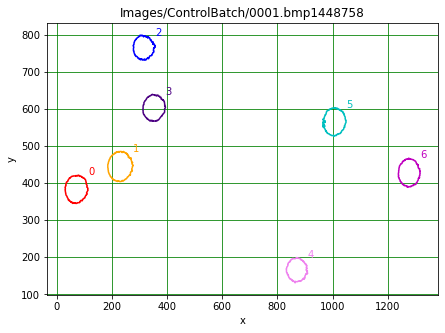

 
Date and time 2021-01-29 18:02:48.191283
Time since last check is 0:00:00.170538


In [340]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import pandas as pd
#
withLabels = True
#
json_file = 'comets.json'
polygons_df = pd.read_json(json_file)
#
# Set up colour list for plots
n_colours = 8
colour_list = ['r', 'orange', 'b', 'indigo', 'violet', 'c', 'm', 'k']
#
rTextRow = 0
rTextCol = 0
#
# Loop over all files in the dataframe
iPoly = 0
for file in polygons_df:
    #
    # Make figure for each file
    plt.figure(figsize = (7, 5))
    plt.title(file)
    plt.xlabel("x")
    plt.ylabel("y")
    n_col = 0
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        plt.plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
        plt.grid(color = 'g')
        #
        if withLabels:
            row_label = np.amax(y_coords) + rTextRow
            col_label = np.amax(x_coords) + rTextCol
            plt.text(col_label, row_label, str(key), color = colour_list[n_col])
        #
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    print(" ")
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot individual polygons

Male plot of each of comets in json file (compare scatter plot with plot of line generating polygon).

Date and time  2021-01-29 18:02:48.213226
 


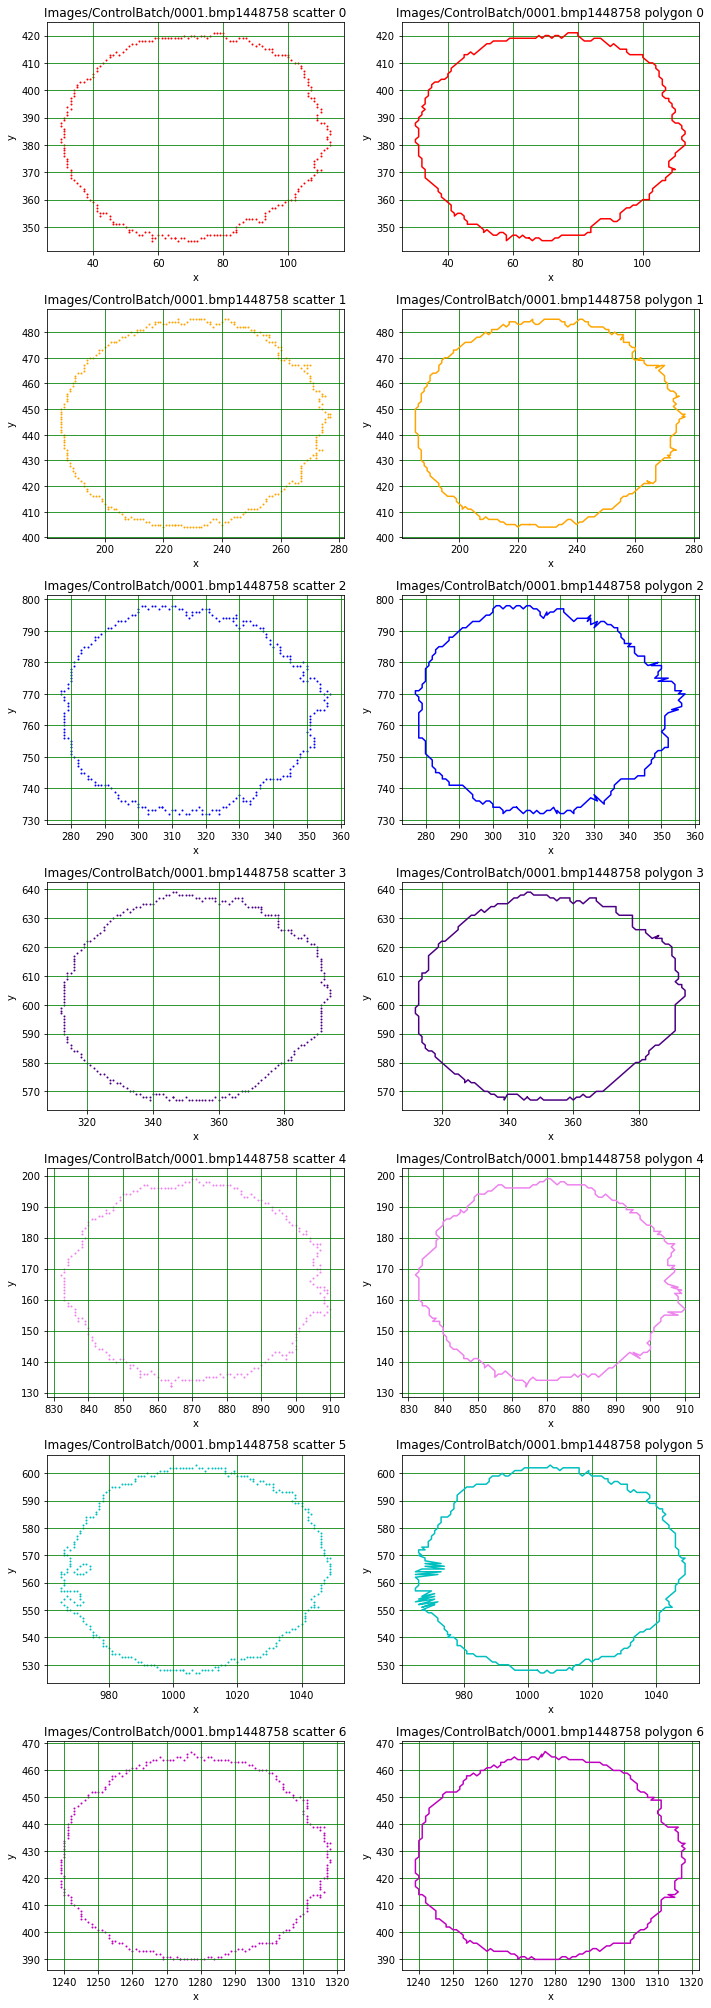

 
Date and time 2021-01-29 18:02:50.283626
Time since last check is 0:00:02.070400
Time since notebook start is 0:00:07.910368


In [341]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
# Loop over all files in the dataframe
for index, file in enumerate(polygons_df):
    #
    # Make figure for each comet
    print(" ")
    number_comets = len(polygons_df[file]['regions'])
    fig1, axs = plt.subplots(number_comets, 2, figsize = (10, 4*number_comets))
    n_plot = 0
    n_col = 0
    #
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        #
        axs[int(key), 0].set_title(file + " scatter " + key)
        axs[int(key), 0].set_xlabel("x")
        axs[int(key), 0].set_ylabel("y")
        axs[int(key), 0].scatter(x_coords, y_coords, s = 1.0, color = colour_list[n_col])
        axs[int(key), 0].grid(color = 'g')
        #
        axs[int(key), 1].set_title(file + " polygon " + key)
        axs[int(key), 1].set_xlabel("x")
        axs[int(key), 1].set_ylabel("y")
        axs[int(key), 1].plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
        axs[int(key), 1].grid(color = 'g')
        #
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    plt.tight_layout()
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))